In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('/content/MSFT.csv')

In [7]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,101.650002,102.250000,101.250000,101.849998,96.329498,18212000
1,2018-07-10,102.000000,102.510002,101.860001,102.120003,96.584877,19293100
2,2018-07-11,101.150002,102.339996,101.099998,101.980003,96.452454,19644600
3,2018-07-12,102.769997,104.410004,102.730003,104.190002,98.542671,24335900
4,2018-07-13,104.370003,105.599998,104.089996,105.430000,99.715454,24635200
...,...,...,...,...,...,...,...
1253,2023-06-30,337.750000,342.730011,337.200012,340.540009,340.540009,26823800
1254,2023-07-03,339.190002,340.899994,336.570007,337.989990,337.989990,12508700
1255,2023-07-05,335.089996,341.649994,334.730011,338.149994,338.149994,18172400
1256,2023-07-06,337.299988,342.989990,335.500000,341.269989,341.269989,28161200


In [8]:
df = df[['Date', 'Close']]

In [9]:
df

,Date,Close
0,2018-07-09,101.849998
1,2018-07-10,102.120003
2,2018-07-11,101.980003
3,2018-07-12,104.190002
4,2018-07-13,105.430000
...,...,...
1253,2023-06-30,340.540009
1254,2023-07-03,337.989990
1255,2023-07-05,338.149994
1256,2023-07-06,341.269989


In [10]:
import datetime

def str_to_date(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)

In [11]:
df['Date'] = df['Date'].apply(str_to_date)
df['Date']

<ipython-input-11-0e89dfacca2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_date)


0      2018-07-09
1      2018-07-10
2      2018-07-11
3      2018-07-12
4      2018-07-13
          ...    
1253   2023-06-30
1254   2023-07-03
1255   2023-07-05
1256   2023-07-06
1257   2023-07-07
Name: Date, Length: 1258, dtype: datetime64[ns]

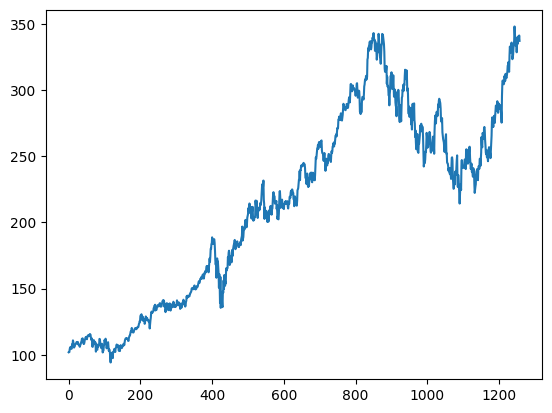

In [12]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])

In [13]:
import numpy as np

def window_data(data, n=3):
    windowed_data = pd.DataFrame()
    windowed_data['Target Date'] = data['Date']
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Close'].shift(i)
    windowed_data['Target'] = data['Close']
    return windowed_data.dropna()

windowed_df = window_data(df, n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
3,2018-07-12,101.849998,102.120003,101.980003,104.190002
4,2018-07-13,102.120003,101.980003,104.190002,105.430000
5,2018-07-16,101.980003,104.190002,105.430000,104.910004
6,2018-07-17,104.190002,105.430000,104.910004,105.949997
7,2018-07-18,105.430000,104.910004,105.949997,105.120003
...,...,...,...,...,...
1253,2023-06-30,334.570007,335.850006,335.049988,340.540009
1254,2023-07-03,335.850006,335.049988,340.540009,337.989990
1255,2023-07-05,335.049988,340.540009,337.989990,338.149994
1256,2023-07-06,340.540009,337.989990,338.149994,341.269989


In [14]:
def windowed_df_to_date_X_Y(windowed_df):
  df_as_np = windowed_df.to_numpy()
  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:,1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, Y = windowed_df_to_date_X_Y(windowed_df)

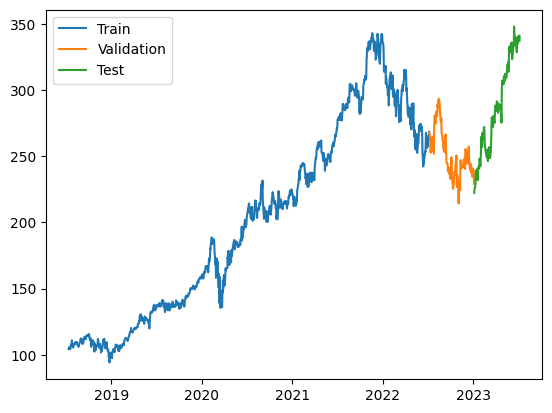

In [15]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], Y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], Y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)])

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['mean_absolute_error']
              )

In [17]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
32/32 [==============================] - 8s 29ms/step - loss: 44634.3359 - mean_absolute_error: 198.6002 - val_loss: 62104.9805 - val_mean_absolute_error: 248.5487
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 42386.8945 - mean_absolute_error: 192.7858 - val_loss: 56528.8086 - val_mean_absolute_error: 237.0643
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 34758.2852 - mean_absolute_error: 171.2187 - val_loss: 40332.9961 - val_mean_absolute_error: 199.9871
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 17971.9258 - mean_absolute_error: 112.1383 - val_loss: 14075.3330 - val_mean_absolute_error: 117.2376
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 6394.1787 - mean_absolute_error: 66.3543 - val_loss: 3164.0544 - val_mean_absolute_error: 53.3842
Epoch 6/100
32/32 [==============================] - 0s 9ms/step - loss: 4215.2261 - mean_absolute_error: 56.2330 - val_loss: 2

32/32 [==============================] - 0s 2ms/step


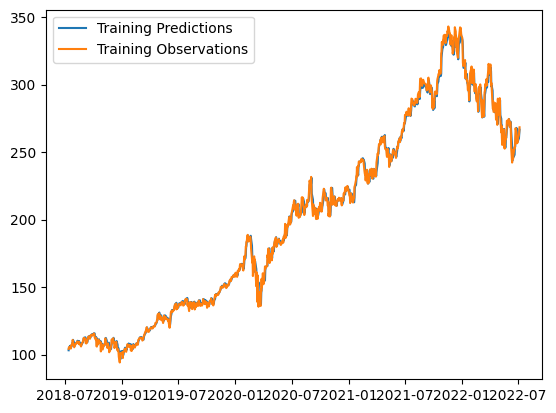

In [18]:
train_pred = model.predict(X_train).flatten()

plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 3ms/step


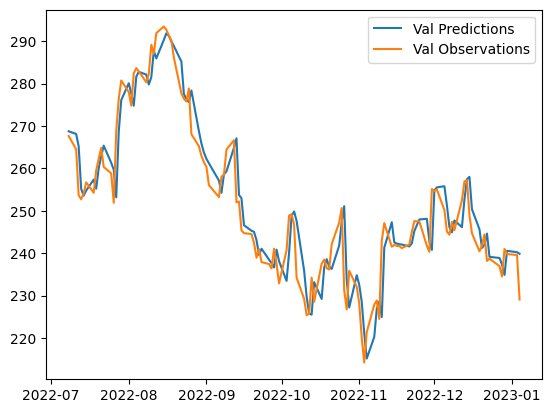

In [20]:
val_pred = model.predict(X_val).flatten()

plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)
plt.legend(['Val Predictions', 'Val Observations'])

4/4 [==============================] - 0s 5ms/step


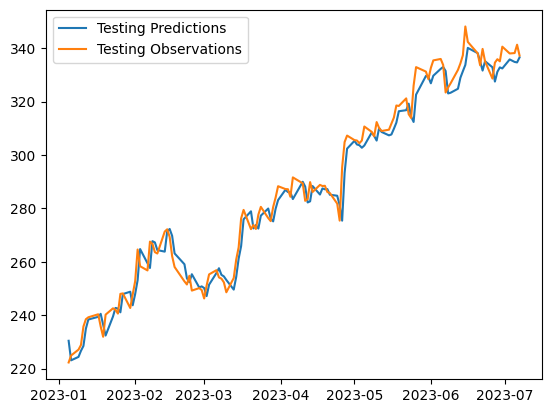

In [21]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

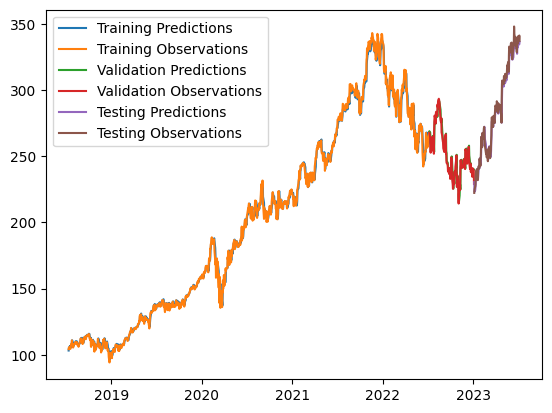

In [23]:
plt.plot(dates_train, train_pred)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_pred)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])